In [ ]:
install.packages('Refs/SM_V7/BSgenome.Schisto.wormbase.WBPS15_1.0.0.tar.gz', 
                 repos = NULL, type="source")

In [3]:
# Load libraries 
library(BSgenome)
library(Biostrings)   
library(GenomeInfoDb)
library(rtracklayer)
library(GenomicFeatures)
library(AnnotationDbi)
library(ArchR)
library(AnnotationForge)
library(OrganismDbi)
library(ensembldb)
library(dplyr)
library(tidyverse)
library(Seurat)
library(SingleCellExperiment)
library( zellkonverter )
library( anndata )
library(BSgenome.Schisto.wormbase.WBPS15)

# Data import and preprocessing

## Set up the reference

In [2]:
addArchRThreads(threads = 1) 

Setting default number of Parallel threads to 1.



In [34]:
### *****Leaving a note for Jesse to change the path here **** 
anno_path <- "Refs/SM_V7/"
db <- ensDbFromGtf(gtf=paste0(anno_path,"schistosoma_mansoni.PRJEA36577.WBPS15.canonical_geneset_converted.gtf"), 
                   organism = "Schistosoma Mansoni", genomeVersion = "WBPS15", version = 15)
edb <- EnsDb(db)
rm(db)

Importing GTF file ... 
OK

Processing metadata ... 
OK

Processing genes ... 

Warning message in ensDbFromGRanges(GTF, outfile = outfile, path = path, organism = organism, :
" I'm missing column(s): 'entrezid'. The corresponding database column(s) will be empty!"
 Attribute availability:

  o gene_id ... OK

  o gene_name ... OK

  o entrezid ... Nope

  o gene_biotype ... OK

OK

Processing transcripts ... 

 Attribute availability:

  o transcript_id ... OK

  o gene_id ... OK

  o transcript_biotype ... OK

OK

Processing exons ... 
OK

Processing chromosomes ... 
Fetch seqlengths from ensembl ... 
Warning message in .getSeqlengthsFromMysqlFolder(organism = organism, ensembl = ensemblVersion, :
"Could not determine length for all seqnames."
FAIL

Warning message in tryGetSeqinfoFromEnsembl(organism, version, seqnames = chroms$seq_name):
"Unable to retrieve sequence lengths from Ensembl."
OK

Generating index ... 
OK

  -------------

Verifying validity of the information in the da

In [35]:
# Making a new annotation file 
gene.ranges <- genes(edb)
gene.ranges = as(gene.ranges, "data.frame")
tmp <- gene.ranges[,-c(7,8,9,10,11)]
rownames(test) <- NULL
gene.ranges = makeGRangesFromDataFrame(tmp,keep.extra.columns=TRUE) 
gene.ranges$symbol <- gene.ranges$gene_id
tss.ranges <- resize(gene.ranges, 1, "start")
exon.ranges = exons(edb)
exon.ranges = as(exon.ranges, "data.frame")
exon.ranges$gene_id <- sub("...[^.]+$", "", exon.ranges$exon_id) 
exon.ranges$symbol <- sub("...[^.]+$", "", exon.ranges$exon_id) 
tmp1 <- exon.ranges[,-c(6)]
rownames(test1) <- NULL
exon.ranges = makeGRangesFromDataFrame(tmp1,keep.extra.columns=TRUE)

In [36]:
geneAnnotation = createGeneAnnotation(
  TSS = tss.ranges, 
  exons = exon.ranges, 
  genes = gene.ranges
)

In [18]:
genome <- getBSgenome(BSgenome.Schisto.wormbase.WBPS15)
chrRanges <- as( seqinfo(genome), "GRanges" )
blacklist <- chrRanges["SM_V7_MITO"] # mitochondria chromosomes

addArchRChrPrefix(chrPrefix = FALSE)

genomeAnno <- createGenomeAnnotation( genome=genome, blacklist=blacklist, chromSizes=chrRanges )
# This next step is potentially necessary due to some ArchR bugs ...
genomeAnno$chromSizes <- genomeAnno$chromSizes[unique(seqnames(tss))]
####
genomeAnno

ArchR is now disabling the requirement of chromosome prefix = 'chr'

Getting genome..

Using provided chromSizes..

Using provided blacklist...



List of length 3
names(3): genome chromSizes blacklist

In [ ]:
setwd( "ArchROutputs/Sman/" )
getwd()

## Read in the ATAC data

In [3]:
inputFiles <- c(juvenile1_uncut="../../FragmentFiles/Sman/schisto1_fragments_raw.tsv.gz",
            juvenile2_uncut="../../FragmentFiles/Sman/schisto2_fragments_raw.tsv.gz",
            adult_cut="../../FragmentFiles/Sman/schisto_cut_fragments_raw.tsv.gz",
            adult_uncut="../../FragmentFiles/Sman/schisto_uncut_fragments_raw.tsv.gz")
inputFiles
names(inputFiles)

juvenile1_uncut                      juvenile2_uncut 
     "schisto1_fragments_raw.tsv.gz"      "schisto2_fragments_raw.tsv.gz" 
                           adult_cut                          adult_uncut 
  "schisto_cut_fragments_raw.tsv.gz" "schisto_uncut_fragments_raw.tsv.gz"

[1] "juvenile1_uncut" "juvenile2_uncut" "adult_cut"       "adult_uncut"

In [4]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  geneAnnotation = geneAnnotation,
  genomeAnnotation = genomeAnno,
  minTSS = 6, #Dont set this too high because you can always increase later
  minFrags = 2000, 
  addTileMat = TRUE,
  addGeneScoreMat = TRUE,
  force = TRUE
)

ArchR logging to : ArchRLogs/ArchR-createArrows-754f2ac236be-Date-2022-01-19_Time-19-49-36.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2022-01-19 19:49:36 : Batch Execution w/ safelapply!, 0 mins elapsed.

(adult_uncut : 1 of 4) Checking if completed file exists!

2022-01-19 19:49:37 : (adult_uncut : 1 of 4) Arrow Exists! Overriding since force = TRUE!, 0.002 mins elapsed.

(adult_uncut : 1 of 4) Determining Arrow Method to use!

2022-01-19 19:49:37 : (adult_uncut : 1 of 4) Reading In Fragments from inputFiles (readMethod = tabix), 0.003 mins elapsed.

2022-01-19 19:49:37 : (adult_uncut : 1 of 4) Tabix Bed To Temporary File, 0.003 mins elapsed.

2022-01-19 19:51:37 : (adult_uncut : 1 of 4) Reading TabixFile 1 Percent, 2.009 mins elapsed.

2022-01-19 19:51:43 : (adult_uncut : 1 of 4) Reading TabixFile 2 Percent, 2.103 mins elapsed.

2022-01-19 19:51:48 : (adult_uncut : 1 of 4) Reading TabixFile 3 Percent, 2.186 mins elapsed.

2022-01-19 19:

In [8]:
doubScores <- addDoubletScores(
    input = ArrowFiles,
    k = 10,
    knnMethod = "UMAP",
    LSIMethod = 1
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-754f1a1d68b7-Date-2022-01-19_Time-23-30-10.log
If there is an issue, please report to github with logFile!

2022-01-19 23:30:10 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-01-19 23:30:10 : adult_uncut (1 of 4) :  Computing Doublet Statistics, 0 mins elapsed.

adult_uncut (1 of 4) : UMAP Projection R^2 = 0.9977

adult_uncut (1 of 4) : UMAP Projection R^2 = 0.9977

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
2022-01-19 23:35:54 : adult_cut (2 of 4) :  Computing Doublet Statistics, 5.734 mins elapsed.

adult_cut (2 of 4) : UMAP Projection R^2 = 0.99756

adult_cut (2 of 4) : UMAP Projection R^2 = 0.99756

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
2022-01-19 23:41:28 : juvenile2_uncut (3 of 4) :  Computing Doublet Statistics, 11.309 mins elapsed.

juvenile2_uncut (3 of 4) : UMAP Projection R^2 = 0.9989

In [9]:
# Creating ArchR Project
schisto_all <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "ArchRProjs/init_proj",
  geneAnnotation = geneAnnotation,
  genomeAnnotation = genomeAnno,
  copyArrows = TRUE #This is recommened so that if you modify the Arrow files you have an original copy for later usage.
)

Validating Arrows...

Getting SampleNames...

1 
2 
3 
4 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 
2 
3 
4 


Getting Cell Metadata...

1 
2 
3 
4 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \           

In [10]:
# How to save ArchR project 
saveArchRProject(
  ArchRProj = schisto_all,
  outputDirectory = "ArchRProjs/init_proj",
  overwrite = TRUE,
  load = TRUE,
  dropCells = FALSE,
  logFile = createLogFile("saveArchRProject"),
  threads = getArchRThreads()
)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

class: ArchRProject 
outputDirectory: /media/gary/Chew/Schisto_ATAC/schisto_all/schisto_all_unfiltered 
samples(4): adult_uncut adult_cut juvenile2_uncut juvenile1_uncut
sampleColData names(1): ArrowFiles
cellColData names(15): Sample nMultiFrags ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 37616
medianTSS(1): 11.406
medianFrags(1): 5864

In [40]:
# Filter doublets 
schisto_all_filtered <- filterDoublets(schisto_all_filtered,filterRatio = 1.5)

Filtering 5453 cells from ArchRProject!

	adult_uncut : 1713 of 10687 (16%)

	adult_cut : 1897 of 11248 (16.9%)

	juvenile2_uncut : 915 of 7814 (11.7%)

	juvenile1_uncut : 928 of 7867 (11.8%)



# Clustering

In [42]:
schisto_all <- addIterativeLSI(
    ArchRProj = schisto_all_filtered,
    useMatrix = "TileMatrix", 
    name = "IterativeLSI", 
    iterations = 2, 
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(0.8), 
        sampleCells = 9000,
        n.start = 10
    ), 
    varFeatures = 25000, 
    dimsToUse = 1:30,
    force = TRUE,
    seed = 10,
)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-16701de3142-Date-2022-04-21_Time-17-39-03.log
If there is an issue, please report to github with logFile!

2022-04-21 17:39:08 : Computing Total Across All Features, 0.088 mins elapsed.

2022-04-21 17:39:12 : Computing Top Features, 0.143 mins elapsed.

###########
2022-04-21 17:39:12 : Running LSI (1 of 2) on Top Features, 0.154 mins elapsed.
###########

2022-04-21 17:39:12 : Sampling Cells (N = 10003) for Estimated LSI, 0.154 mins elapsed.

2022-04-21 17:39:12 : Creating Sampled Partial Matrix, 0.154 mins elapsed.

2022-04-21 17:39:44 : Computing Estimated LSI (projectAll = FALSE), 0.679 mins elapsed.

2022-04-21 17:39:54 : Identifying Clusters, 0.845 mins elapsed.

2022-04-21 17:39:59 : Identified 25 Clusters, 0.94 mins elapsed.

2022-04-21 17:39:59 : Saving LSI Iteration, 0.94 mins elapsed.

Length of unique values greater than palette, interpolating..

2022-04-21 17:40:18 : Creating Cluster Matrix on the total

In [69]:
# Clustering 
schisto_all <- addClusters(
    input = schisto_all,
    reducedDims = "IterativeLSI",
    method = "Seurat",
    name = "Clusters",
    resolution = 0.8,#0.8
    maxClusters = 36,
    force=TRUE
)

ArchR logging to : ArchRLogs/ArchR-addClusters-167059651b48-Date-2022-04-21_Time-19-16-11.log
If there is an issue, please report to github with logFile!

Overriding previous entry for Clusters

2022-04-21 19:16:11 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.001 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32163
Number of edges: 1223625

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9589
Number of communities: 51
Elapsed time: 3 seconds


2022-04-21 19:16:33 : Testing Biased Clusters, 0.363 mins elapsed.

2022-04-21 19:16:34 : Testing Outlier Clusters, 0.378 mins elapsed.

2022-04-21 19:16:34 : Identified more clusters than maxClusters allowed (n = 0). Merging clusters to maxClusters (n = 36).
If this is not desired set maxClusters = NULL!, 0.378 mins elapsed.

2022-04-21 19:16:34 : Assigning Cluster Names to 36 Clusters, 0.378 mins elapsed.

2022-04-21 19:16:34 : Finished addClusters, 0.379 mins elapsed.



In [70]:
schisto_all <- addHarmony(
    ArchRProj = schisto_all,
    reducedDims = "IterativeLSI",
    name = "Harmony_ATAC",
    groupBy = "Sample",
    force = TRUE
)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony converged after 7 iterations



In [71]:
schisto_all_filtered <- addUMAP( ArchRProj = schisto_all, reducedDims = "Harmony_ATAC", name = "UMAP_Harmony",
                    nNeighbors = 30, minDist = 0.5, metric = "cosine", force=TRUE )

19:17:04 UMAP embedding parameters a = 0.583 b = 1.334

19:17:04 Read 32163 rows and found 30 numeric columns

19:17:04 Using Annoy for neighbor search, n_neighbors = 30

19:17:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:17:06 Writing NN index file to temp file /tmp/RtmpQj1LM5/file16706e9ad870

19:17:06 Searching Annoy index using 6 threads, search_k = 3000

19:17:08 Annoy recall = 100%

19:17:08 Commencing smooth kNN distance calibration using 6 threads

19:17:09 Initializing from normalized Laplacian + noise

19:17:12 Commencing optimization for 200 epochs, with 1395764 positive edges

19:17:23 Optimization finished

19:17:23 Creating temp model dir /tmp/RtmpQj1LM5/dir16701d2102b

19:17:23 Creating dir /tmp/RtmpQj1LM5/dir16701d2102b

19:17:25 Changing to /t

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-1670c335d03-Date-2022-04-21_Time-19-17-26.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-1670c335d03-Date-2022-04-21_Time-19-17-26.log



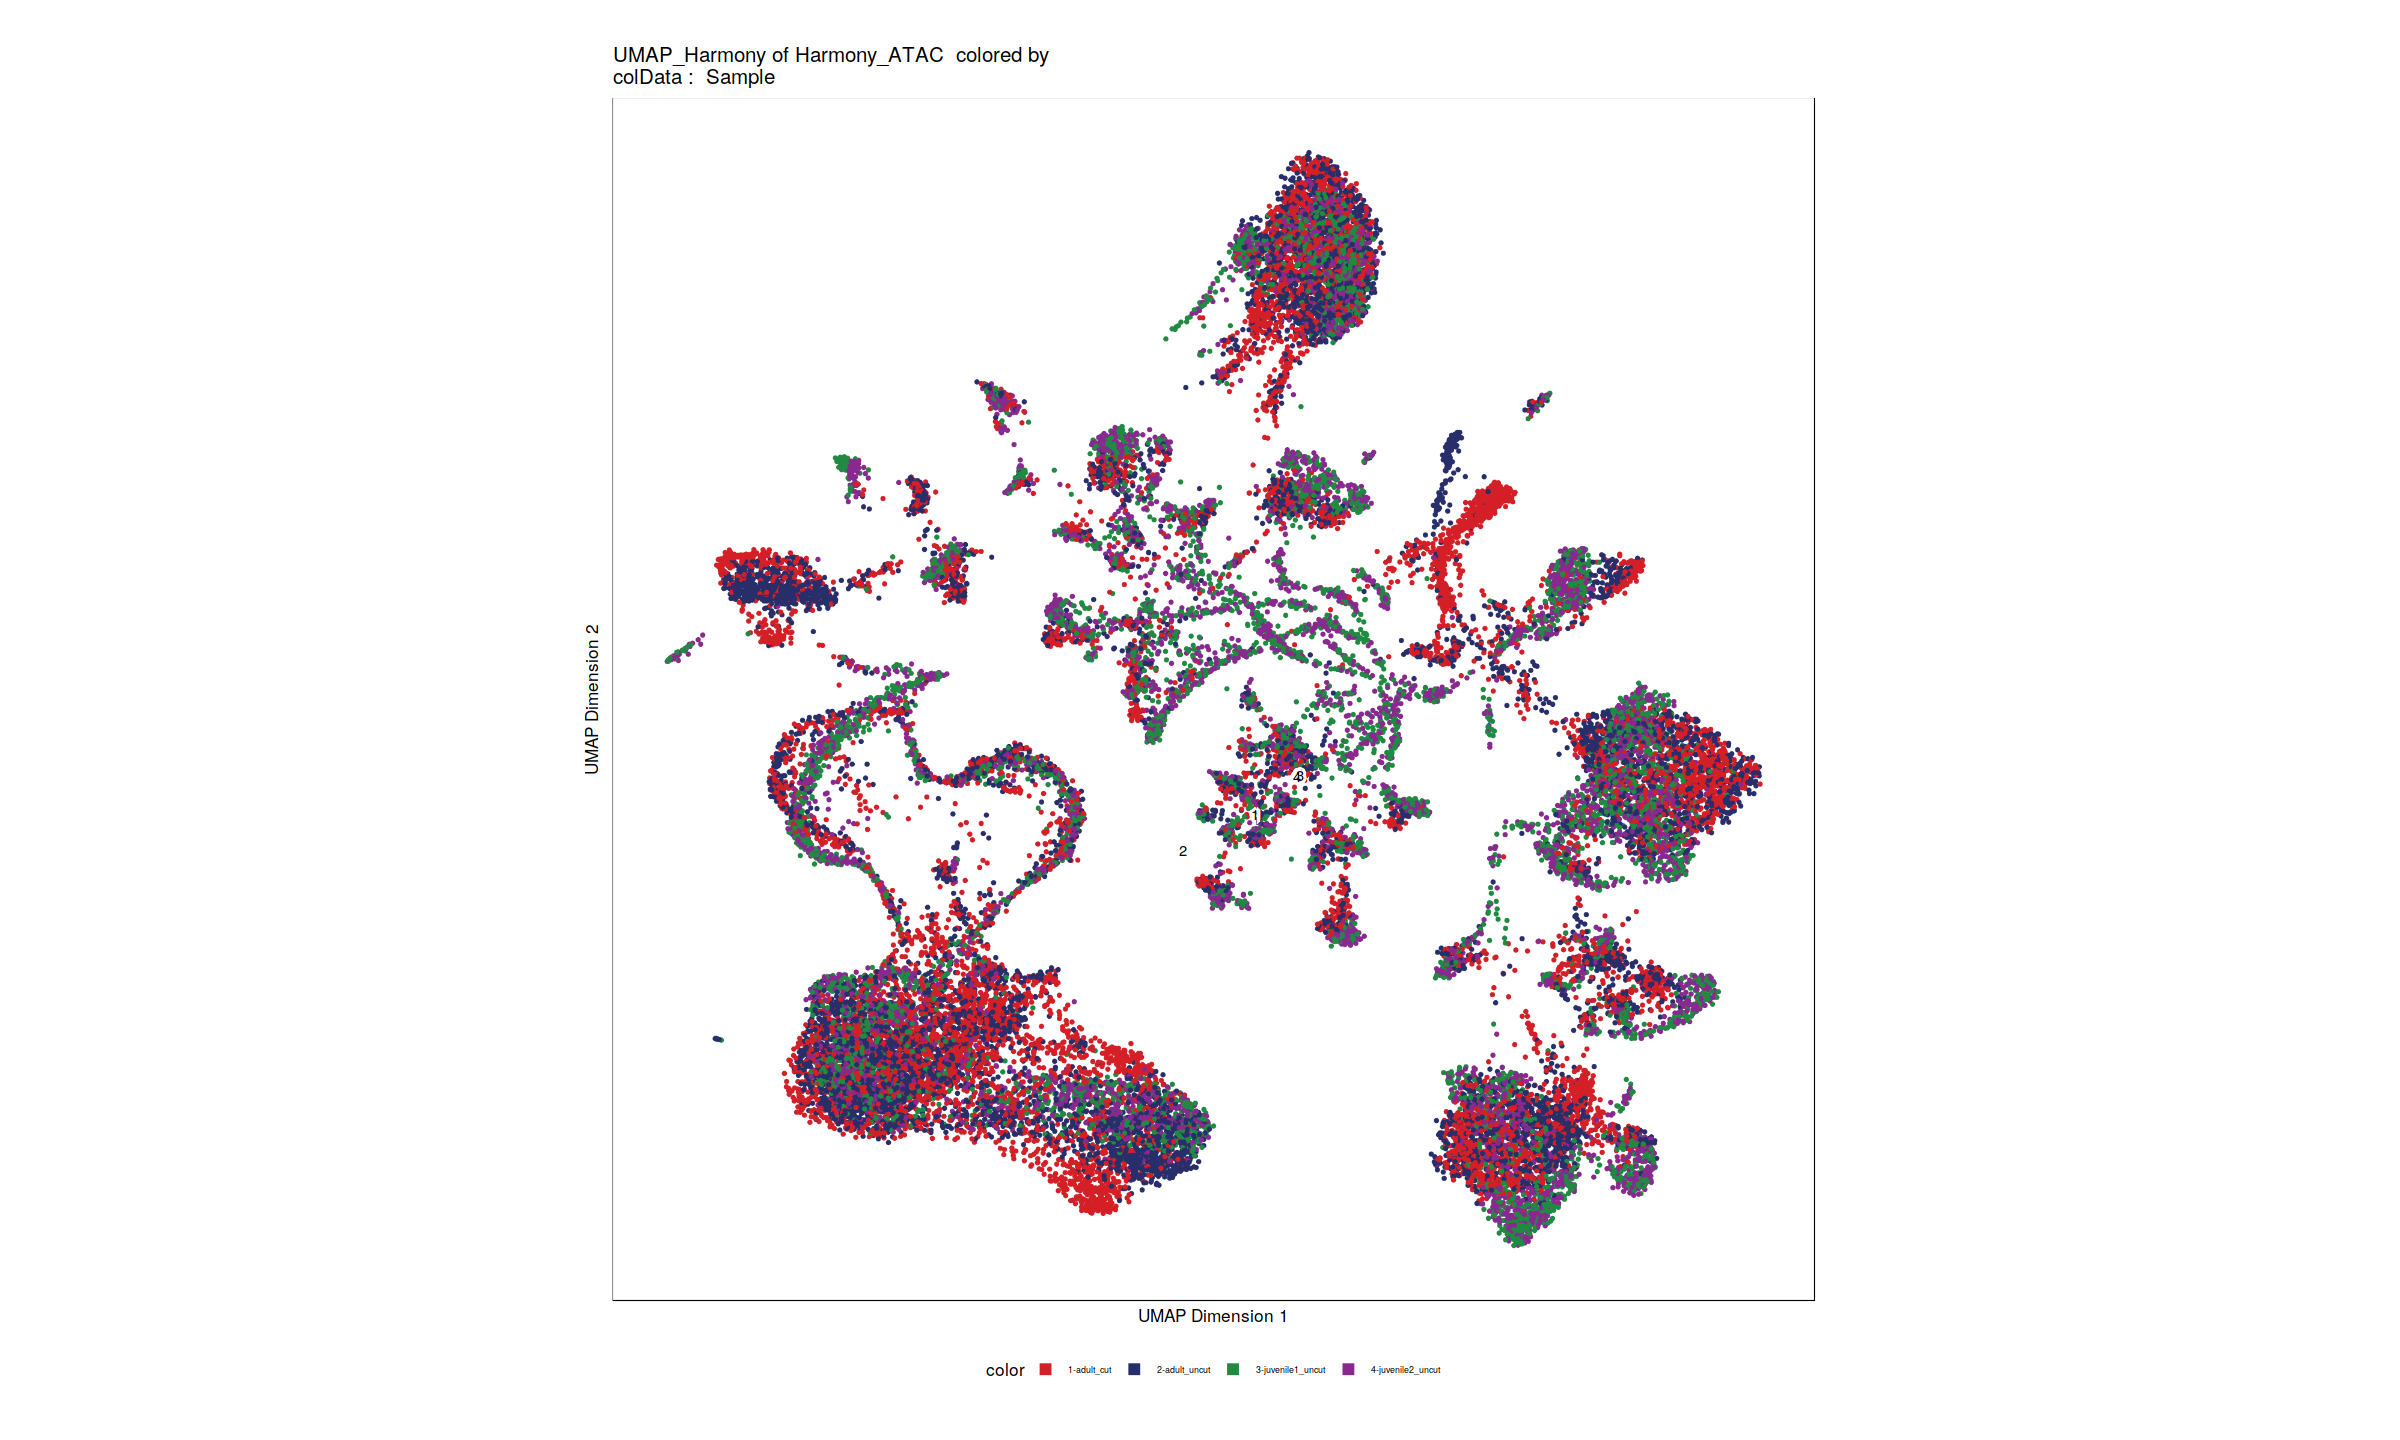

In [72]:
p1 <- plotEmbedding(ArchRProj = schisto_all_filtered, colorBy = "cellColData", name = "Sample", embedding = "UMAP_Harmony")

options(repr.plot.width=20, repr.plot.height=12)
p1 

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-16703530858-Date-2022-04-21_Time-19-17-28.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-16703530858-Date-2022-04-21_Time-19-17-28.log



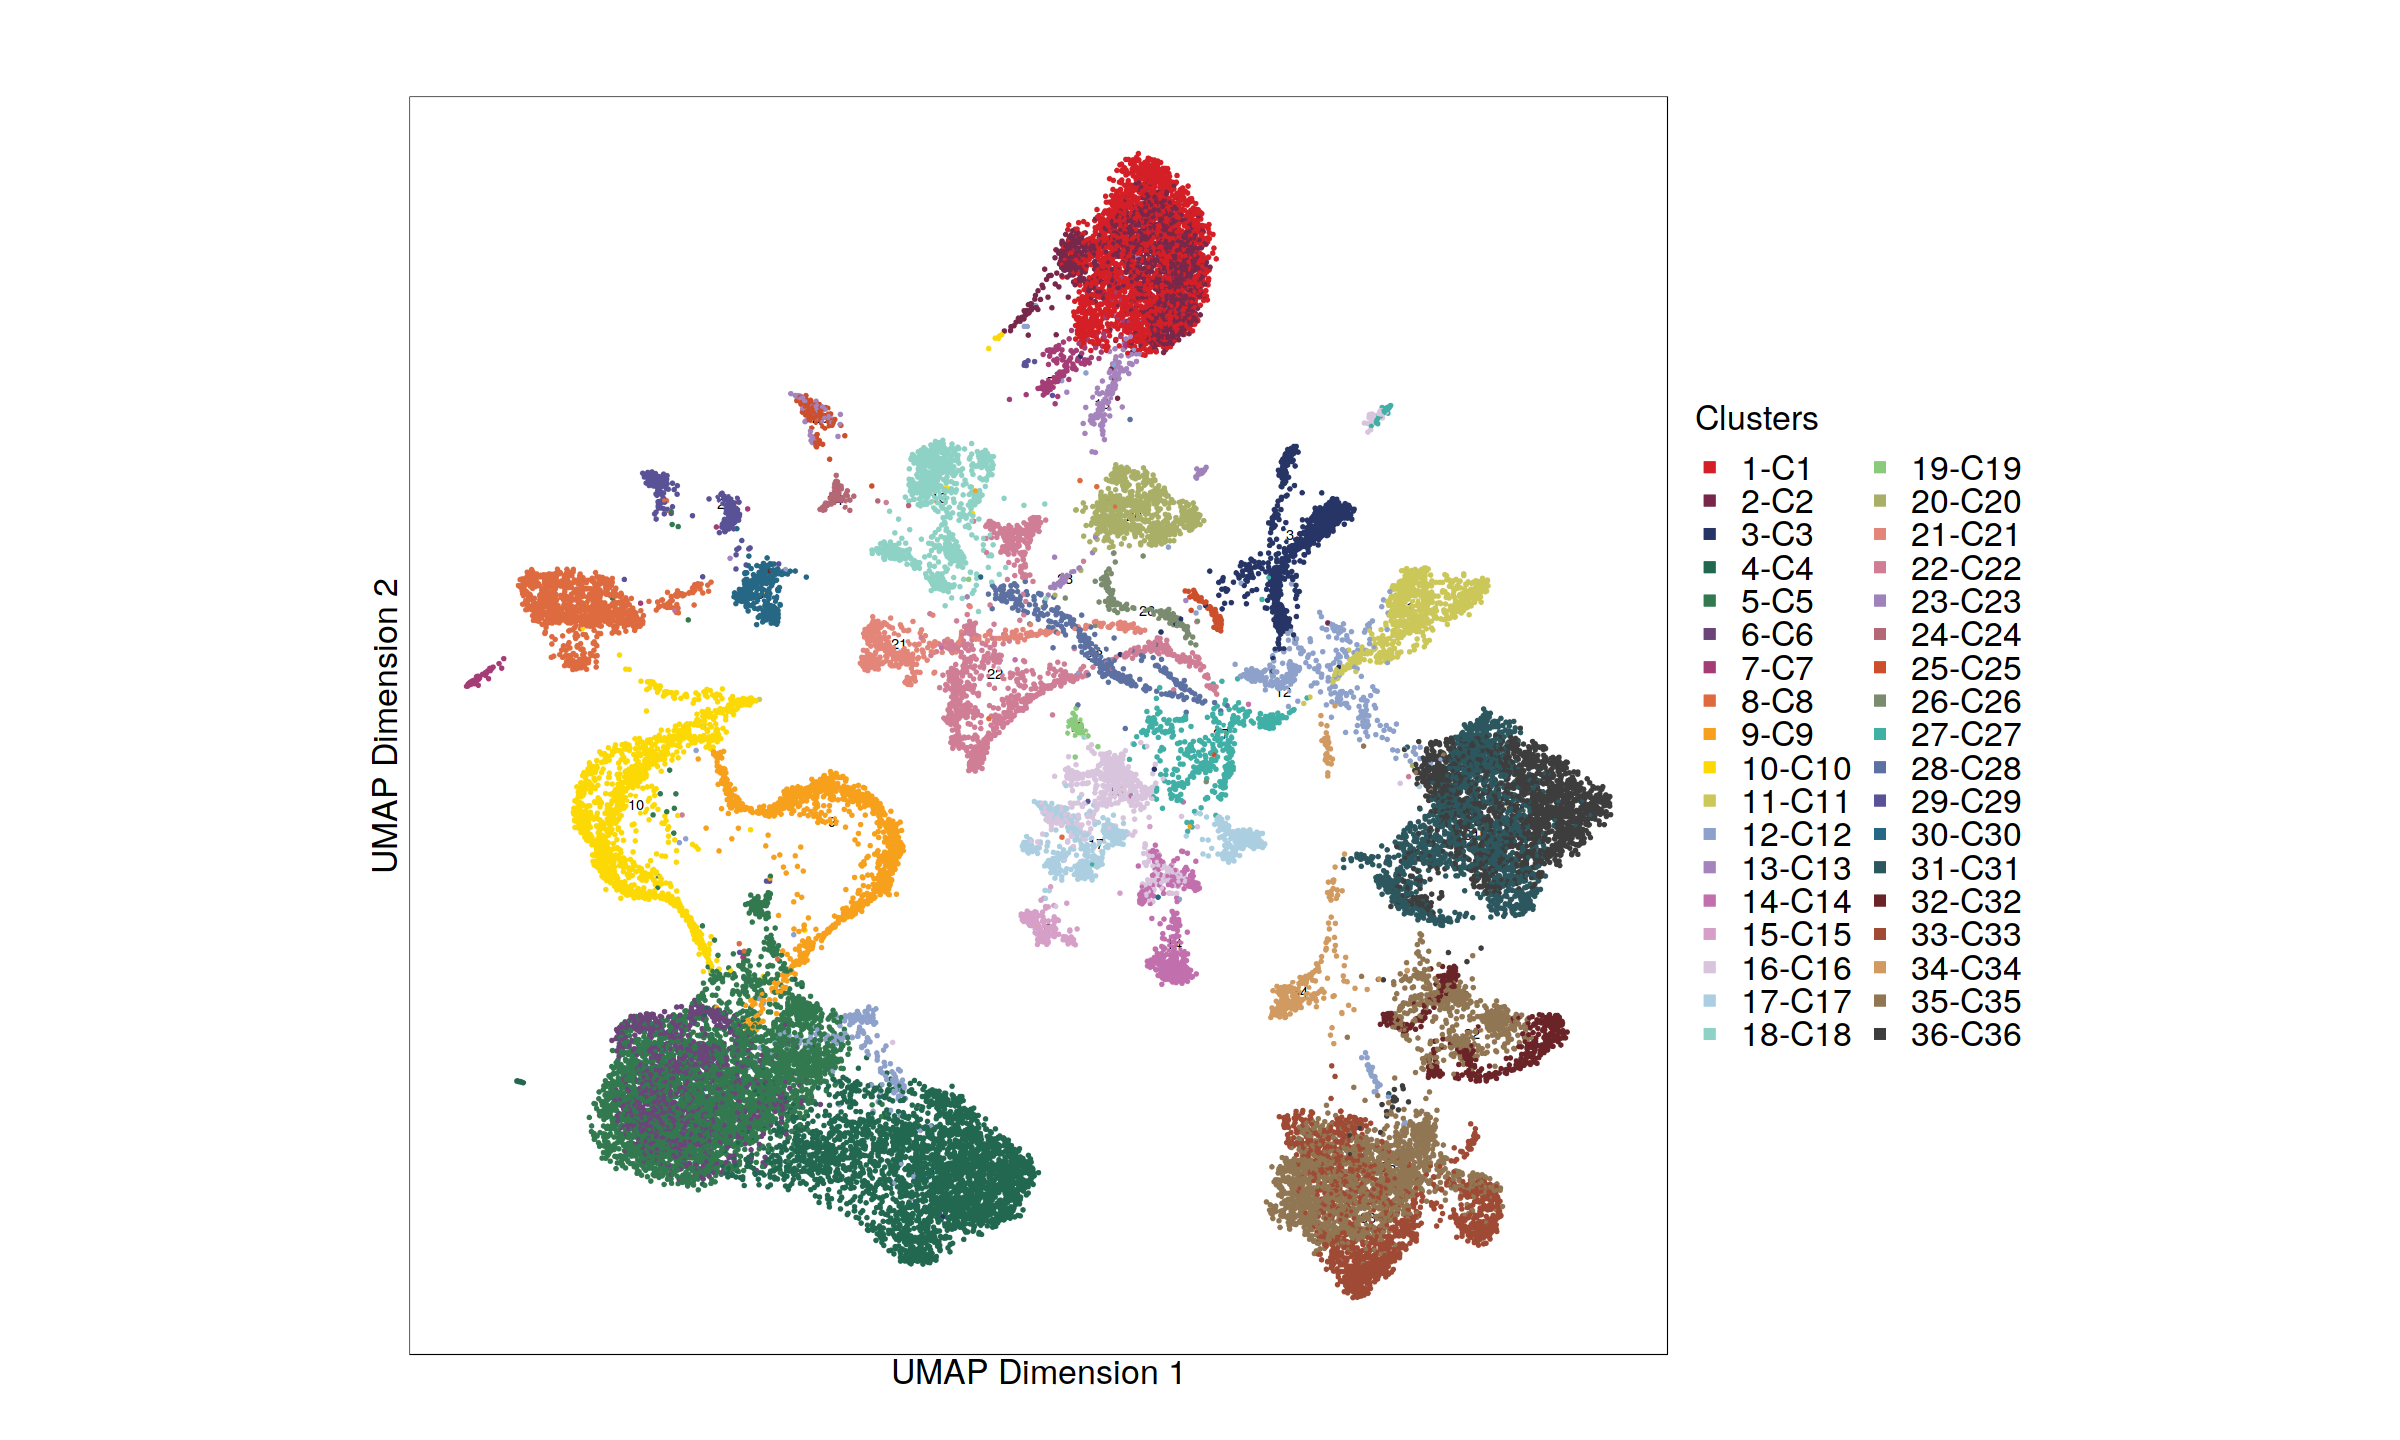

In [73]:
p1 <- plotEmbedding(ArchRProj = schisto_all_filtered, colorBy = "cellColData", name = "Clusters", embedding = "UMAP_Harmony")
p <- p1 + 
    theme_ArchR(baseSize = 20, legendTextSize = 20,legendPosition="right") + 
    #theme_set(theme_classic(base_size = 20))+
    scale_y_continuous(breaks = NULL) +
    scale_x_continuous(breaks = NULL) +
    geom_point(size = 0.15) + 
    labs(title = "", color = "Clusters")
p

# RNA integration

We first split the ArchR object into adult and juvenile as adult data don't have corresponding RNA, and we needed to integrate

In [ ]:
adult <- loadArchRProject(path = "./adult_encode/", force = FALSE, showLogo = TRUE)
juvenile <- loadArchRProject(path = "./ArchRproj/juvenile_integrated_annotated/", force = FALSE, showLogo = FALSE)

### Adult integration from GSE146736 

In [3]:
Schisto_RNA = readRDS("adult_RNA_Wendt_et_al_2020.rds")

[1] "orig.ident"           "nCount_RNA"           "nFeature_RNA"        
 [4] "run"                  "percent.mt"           "Group"               
 [7] "nCount_integrated"    "nFeature_integrated"  "integrated_snn_res.5"
[10] "integrated_snn_res.3" "cell_type"

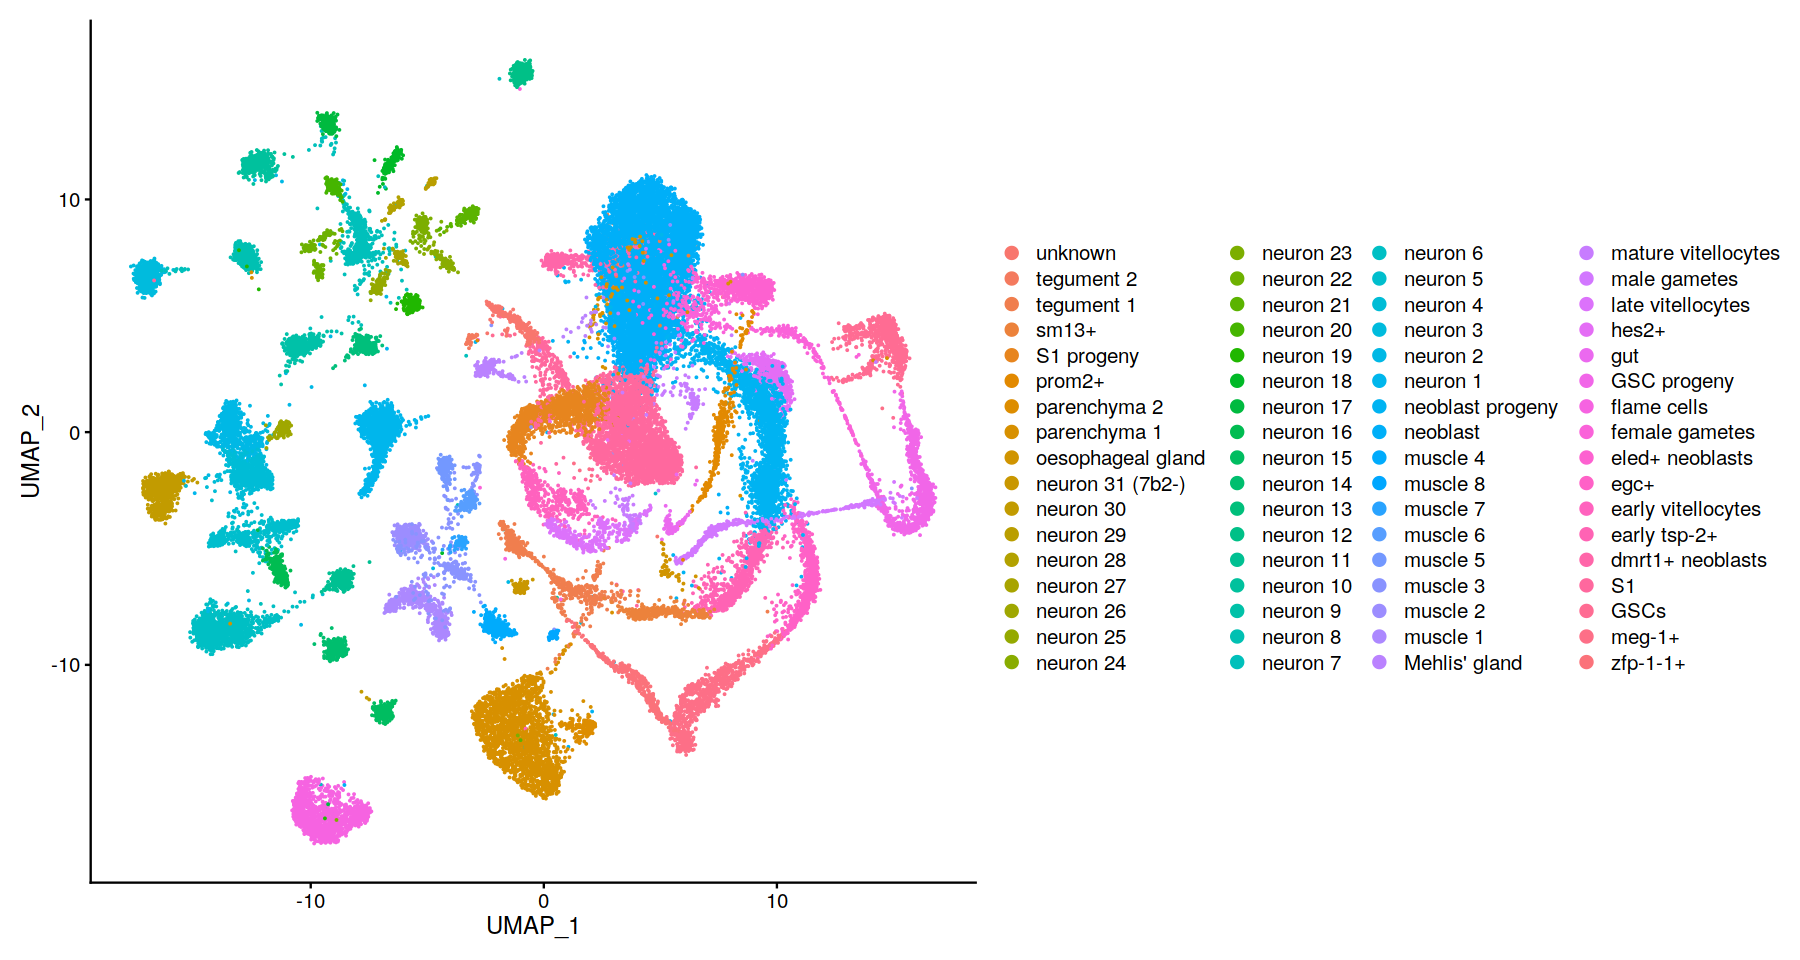

In [20]:
Schisto_RNA$cell_type = Idents(Schisto_RNA)
colnames(Schisto_RNA@meta.data)

options(repr.plot.width=15, repr.plot.height=8)
DimPlot(Schisto_RNA, reduction = "umap")
options(repr.plot.width=8, repr.plot.height=8)

temp =  CreateSeuratObject(
    counts=Schisto_RNA@assays$RNA@counts,
    meta.data=Schisto_RNA@meta.data)

In [22]:
# Unconstrained integration 
adult <- addGeneIntegrationMatrix(
    ArchRProj = adult, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "Harmony",
    seRNA = temp,
    addToArrow = TRUE,
    groupRNA = "cell_type",
    nameCell = "predictedCell_Un",
    nameGroup = "predictedGroup_Un",
    nameScore = "predictedScore_Un",
    force = TRUE
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-1069203ebed6-Date-2022-05-24_Time-17-22-07.log
If there is an issue, please report to github with logFile!

2022-05-24 17:22:07 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2022-05-24 17:22:07 : Checking ATAC Input, 0.002 mins elapsed.

2022-05-24 17:22:08 : Checking RNA Input, 0.009 mins elapsed.

2022-05-24 17:22:11 : Found 10150 overlapping gene names from gene scores and rna matrix!, 0.073 mins elapsed.

2022-05-24 17:22:11 : Creating Integration Blocks, 0.073 mins elapsed.

2022-05-24 17:22:12 : Prepping Interation Data, 0.081 mins elapsed.

2022-05-24 17:22:14 : Computing Integration in 2 Integration Blocks!, 0 mins elapsed.

2022-05-24 17:22:14 : Block (1 of 2) : Computing Integration, 0 mins elapsed.

2022-05-24 17:22:16 : Block (1 of 2) : Identifying Variable Genes, 0.027 mins elapsed.

2022-05-24 17:22:18 : Block (1 of 2) : Getting GeneScoreMatrix, 0.06 mins elapsed.

2022-05-24 17:22:33 : 

In [23]:
# Constrained integration 
cM <- as.matrix(confusionMatrix(adult$Clusters, adult$predictedGroup_Un))
cM
labelOld <- rownames(cM)
labelOld
labelNew <- colnames(cM)[apply(cM, 1, which.max)]
labelNew

,neuron 31 (7b2-),muscle 2,flame cells,neuron 14,muscle 1,parenchyma 1,oesophageal gland,neoblast,tegument 2,muscle 4,⋯,early tsp-2+,neuron 5,GSCs,neuron 9,neoblast progeny,neuron 21,egc+,muscle 7,neuron 11,early vitellocytes
C10,23,11,17,11,13,4,10,68,1,15,⋯,3,3,5,1,0,0,0,0,0,0
C6,34,0,0,149,0,0,0,0,1,0,⋯,0,15,0,1,0,3,0,0,1,0
C14,0,0,0,0,0,1642,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
C36,0,1544,0,0,2,0,0,0,0,77,⋯,0,0,0,0,0,0,0,0,0,0
C33,1,8,0,3,460,0,0,0,0,48,⋯,0,1,0,0,0,0,0,0,0,0
C34,0,44,0,0,1264,0,0,0,0,30,⋯,0,0,0,0,0,0,0,0,0,0
C7,138,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
C12,7,0,8,0,0,91,2,0,0,0,⋯,0,0,0,3,0,0,0,0,0,0
C13,0,0,28,0,0,51,18,0,21,0,⋯,0,0,0,0,0,0,0,0,0,0
C17,0,0,0,0,0,0,26,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] "C10" "C6"  "C14" "C36" "C33" "C34" "C7"  "C12" "C13" "C17" "C31" "C25"
[13] "C16" "C21" "C18" "C26" "C38" "C27" "C39" "C19" "C37" "C15" "C24" "C28"
[25] "C1"  "C29" "C2"  "C22" "C30" "C32" "C3"  "C35" "C8"  "C23" "C4"  "C9" 
[37] "C11" "C20" "C5"

[1] "neoblast"            "neuron 3"            "parenchyma 1"       
 [4] "muscle 2"            "muscle 1"            "muscle 1"           
 [7] "neuron 31 (7b2-)"    "parenchyma 1"        "parenchyma 1"       
[10] "gut"                 "mature vitellocytes" "tegument 1"         
[13] "gut"                 "oesophageal gland"   "gut"                
[16] "oesophageal gland"   "flame cells"         "oesophageal gland"  
[19] "tegument 2"          "oesophageal gland"   "muscle 4"           
[22] "parenchyma 1"        "oesophageal gland"   "tegument 1"         
[25] "neuron 6"            "meg-1+"              "neuron 2"           
[28] "oesophageal gland"   "sm13+"               "late vitellocytes"  
[31] "neuron 30"           "muscle 4"            "S1"                 
[34] "zfp-1-1+"            "neuron 1"            "GSCs"               
[37] "neoblast"            "tegument 1"          "neuron 9"

In [24]:
adult$Clusters1 <- mapLabels(schisto_all$Clusters, newLabels = labelNew, oldLabels = labelOld)

In [26]:
saveArchRProject(
  ArchRProj = adult,
  outputDirectory = "adult_encode",
  overwrite = TRUE,
  load = TRUE,
  dropCells = FALSE,
  logFile = createLogFile("saveArchRProject"),
  threads = getArchRThreads()
)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

class: ArchRProject 
outputDirectory: /media/gary/Chew/Schisto_ATAC/schisto_all/adult_encode 
samples(2): adult_uncut_v01 adult_cut_v01
sampleColData names(1): ArrowFiles
cellColData names(20): Sample TSSEnrichment ... predictedScore_Un
  Clusters1
numberOfCells(1): 18325
medianTSS(1): 10.325
medianFrags(1): 5323

### Juvenile RNA added from our multiome data 

In [11]:
# Now, let's try to incorporate RNA data 
bcRNA <- readLines( "../../Refs/737K-arc-v1.all.txt" )
bcATAC <- readLines( "../../Refs/737K-arc-v1.atac.revcomp.unsrt.txt")

Warning message in readLines("./737K-arc-v1-RNA.txt"):
"incomplete final line found on './737K-arc-v1-RNA.txt'"
Warning message in readLines("./737K-arc-v1.atac.revcomp.unsrt.txt"):
"incomplete final line found on './737K-arc-v1.atac.revcomp.unsrt.txt'"


In [12]:
features1 <- read.table( "../../GEXCounts/Sman/STARsolo/Schisto1_juvenile/Solo.out/GeneFull/raw/features.tsv",sep='\t',header=FALSE )
features1$V1 <- sub("_","-",features1$V1)
juv_1 <- ReadMtx(mtx="../../GEXCounts/Sman/STARsolo/Schisto1_juvenile/Solo.out/GeneFull/raw/matrix.mtx",
                cells="../../GEXCounts/Sman/STARsolo/Schisto1_juvenile/Solo.out/GeneFull/raw/barcodes.tsv",
                features="../../GEXCounts/Sman/STARsolo/Schisto1_juvenile/Solo.out/GeneFull/raw/features_v02.tsv",
                feature.column=1, mtx.transpose=F )

colnames(juv_1) <- paste0( "juvenile1_uncut#",  data.frame( bcRNA, bcATAC, row.names=1 )[colnames(juv_1),] )


In [13]:
juv_2 <- ReadMtx( mtx="../../GEXCounts/Sman/STARsolo/Schisto2_juvenile/Solo.out/GeneFull/raw/matrix.mtx",
                cells="../../GEXCounts/Sman/STARsolo/Schisto2_juvenile/Solo.out/GeneFull/raw/barcodes.tsv",
                features="../../GEXCounts/Sman/STARsolo/Schisto2_juvenile/Solo.out/GeneFull/raw/features_v02.tsv",
                feature.column=1, mtx.transpose=F )

colnames(juv_2) <- paste0( "juvenile2_uncut#",  data.frame( bcRNA, bcATAC, row.names=1 )[colnames(juv_2),] )


In [14]:
juv <- cbind( juv_1, juv_2)
sceRNA <- SummarizedExperiment( list(counts=juv[geneAnnotation$genes$gene_id,colnames(juv) %bcin% schisto_all$cellNames]), rowRanges=geneAnnotation$genes )
juvenile <- addGeneExpressionMatrix(input=juvenile, seRNA=sceRNA,force=TRUE)


ArchR logging to : ArchRLogs/ArchR-addGeneExpressionMatrix-4b271480a804-Date-2022-05-25_Time-12-23-12.log
If there is an issue, please report to github with logFile!

Overlap w/ scATAC = 1

2022-05-25 12:23:13 : 

Overlap Per Sample w/ scATAC : juvenile1_uncut=7867,juvenile2_uncut=7814

2022-05-25 12:23:13 : 

2022-05-25 12:23:21 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-05-25 12:23:21 : Adding juvenile2_uncut to GeneExpressionMatrix for Chr (1 of 193)!, 0.011 mins elapsed.

2022-05-25 12:23:24 : Adding juvenile2_uncut to GeneExpressionMatrix for Chr (2 of 193)!, 0.048 mins elapsed.

2022-05-25 12:23:26 : Adding juvenile2_uncut to GeneExpressionMatrix for Chr (3 of 193)!, 0.082 mins elapsed.

2022-05-25 12:23:28 : Adding juvenile2_uncut to GeneExpressionMatrix for Chr (4 of 193)!, 0.124 mins elapsed.

2022-05-25 12:23:30 : Adding juvenile2_uncut to GeneExpressionMatrix for Chr (5 of 193)!, 0.155 mins elapsed.

2022-05-25 12:23:32 : Adding juvenile2_uncut to GeneExpression

In [66]:
saveArchRProject(
  ArchRProj = juvenile,
  outputDirectory = "ArchRproj/juvenile_integrated_annotated/",
  overwrite = TRUE,
  load = TRUE,
  dropCells = FALSE,
  logFile = createLogFile("saveArchRProject"),
  threads = getArchRThreads()
)

Copying ArchRProject to new outputDirectory : /media/gary/Chew/Schisto_ATAC/schisto_all/ArchRproj/juvenile_integrated_annotated

Copying Arrow Files...

Copying Arrow Files (1 of 2)

Copying Arrow Files (2 of 2)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 4): Embeddings

Copying Other Files (2 of 4): LSI_ATAC

Copying Other Files (3 of 4): LSI_RNA

Copying Other Files (4 of 4): RNAIntegration

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /        

class: ArchRProject 
outputDirectory: /media/gary/Chew/Schisto_ATAC/schisto_all/ArchRproj/juvenile_integrated_annotated 
samples(2): juvenile2_uncut juvenile1_uncut
sampleColData names(1): ArrowFiles
cellColData names(24): Sample nMultiFrags ... predictedScore_Un
  Clusters1
numberOfCells(1): 15681
medianTSS(1): 12.805
medianFrags(1): 5858

Extracting integrated gene expression from adult and gene expression from juvenile, and reintegrate to our original adult+juvenile ArchR object 

In [8]:
gsmat <- getMatrixFromProject(adult,useMatrix="GeneIntegrationMatrix")
sce <- SummarizedExperiment(list(counts=assay(gsmat)))
rownames(sce) <- rowData (gsmat)$name
rownames(sce) <- sub("-", "_", rownames(sce)) 


ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-45d323397603-Date-2022-02-02_Time-23-09-21.log
If there is an issue, please report to github with logFile!

2022-02-02 23:12:30 : Organizing colData, 3.151 mins elapsed.

2022-02-02 23:12:30 : Organizing rowData, 3.152 mins elapsed.

2022-02-02 23:12:30 : Organizing rowRanges, 3.152 mins elapsed.

2022-02-02 23:12:30 : Organizing Assays (1 of 1), 3.152 mins elapsed.

2022-02-02 23:12:31 : Constructing SummarizedExperiment, 3.177 mins elapsed.

2022-02-02 23:12:32 : Finished Matrix Creation, 3.185 mins elapsed.



In [9]:
gsmat2 <- getMatrixFromProject(juvenile,useMatrix="GeneExpressionMatrix")
sce2 <- SummarizedExperiment(list(counts=assay(gsmat2)))
rownames(sce2) <- rowData (gsmat2)$name
rownames(sce2) <- sub("-", "_", rownames(sce2))

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-45d33fa0f701-Date-2022-02-02_Time-23-12-32.log
If there is an issue, please report to github with logFile!

2022-02-02 23:12:51 : Organizing colData, 0.325 mins elapsed.

2022-02-02 23:12:51 : Organizing rowData, 0.325 mins elapsed.

2022-02-02 23:12:51 : Organizing rowRanges, 0.325 mins elapsed.

2022-02-02 23:12:51 : Organizing Assays (1 of 1), 0.325 mins elapsed.

2022-02-02 23:12:52 : Constructing SummarizedExperiment, 0.327 mins elapsed.

2022-02-02 23:12:52 : Finished Matrix Creation, 0.339 mins elapsed.



In [10]:
sce2 <- sce2[rownames(sce2) %bcin% rownames(sce),] # this line is needed to match the gene names between the two dataframe 


In [12]:
## 
setequal(rownames(sce2), rownames(sce)) ## TRUE
idx <- match(rownames(sce2), rownames(sce))
temp <- cbind(sce2, sce[idx,])
rownames(temp) <- sub("_", "-", rownames(temp)) 

sce <- sce[idx,]
scecombined<-cbind(assay(sce2), assay(sce))
test <- geneAnnotation$genes
test <- test[test$gene_id %in% rownames(temp)]
juv_adult <-SummarizedExperiment(assays=list(counts=scecombined), rowRanges= test)
rownames(juv_adult) <- sub("_", "-", rownames(juv_adult)) 


[1] TRUE

In [13]:
smProj <- addGeneExpressionMatrix(input=schisto_all_filtered, seRNA=juv_adult,force=TRUE)
smProj <- smProj[!is.na(smProj$Gex_nUMI)]
smProj

ArchR logging to : ArchRLogs/ArchR-addGeneExpressionMatrix-45d34a62a94f-Date-2022-02-02_Time-23-13-06.log
If there is an issue, please report to github with logFile!

Overlap w/ scATAC = 1

2022-02-02 23:13:07 : 

Overlap Per Sample w/ scATAC : adult_cut=9351,adult_uncut=8974,juvenile1_uncut=6939,juvenile2_uncut=6899

2022-02-02 23:13:07 : 

2022-02-02 23:13:18 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-02-02 23:13:22 : Adding adult_uncut to GeneExpressionMatrix for Chr (1 of 193)!, 0.063 mins elapsed.

2022-02-02 23:13:26 : Adding adult_uncut to GeneExpressionMatrix for Chr (2 of 193)!, 0.123 mins elapsed.

2022-02-02 23:13:27 : Adding adult_uncut to GeneExpressionMatrix for Chr (3 of 193)!, 0.143 mins elapsed.

2022-02-02 23:13:28 : Adding adult_uncut to GeneExpressionMatrix for Chr (4 of 193)!, 0.169 mins elapsed.

2022-02-02 23:13:30 : Adding adult_uncut to GeneExpressionMatrix for Chr (5 of 193)!, 0.19 mins elapsed.

2022-02-02 23:13:31 : Adding adult_uncut to GeneExp

class: ArchRProject 
outputDirectory: /media/gary/Chew/Schisto_ATAC/schisto_all/schisto_all_unfiltered 
samples(4): adult_uncut adult_cut juvenile2_uncut juvenile1_uncut
sampleColData names(1): ArrowFiles
cellColData names(19): Sample nMultiFrags ... Gex_MitoRatio
  Gex_RiboRatio
numberOfCells(1): 32163
medianTSS(1): 11.534
medianFrags(1): 5383

# Export gene scores matrix

In [ ]:
gsmat <- getMatrixFromProject( smProj, useMatrix="GeneScoreMatrix" )

sce <- SingleCellExperiment( list(counts=gsmat) )
rownames(sce) <- rowData( gsmat )$name
colData(sce) <- colData( gsmat )[,c("SeuratClusters")]
# Export the data
adata <- SCE2AnnData( sce )
anndata::write_h5ad( adata, "Sman.genescores.h5ad" )

rm( momat )
rm( sce )
rm( adata )

# Updating annotations based on SAMap

In [ ]:
annots <- read.csv( '../../Metadata/Sman.final_cluster_annots.csv', 
                    header=TRUE )
head(annots)

In [ ]:
smProj <- addCellColData( smProj, data=annots$GroupFigure, name='GroupFigure',
                          cells=rownames(annots), force=TRUE )

In [ ]:
p <- plotEmbedding(
    smProj, 
    colorBy = "cellColData", 
    name = "GroupFigure", 
    embedding = "UMAP_Harmony"
)
options(repr.plot.width=20, repr.plot.height=12)

p <- p + theme_set(theme_classic(base_size = 15)) + labs(title = "", color = "Clusters") 
p

# Adding in the peak matrix

In [ ]:
peaks <- read.table("../../Peaks/Sman.merged_peaks.narrowPeak")[,c("V1","V2","V3","V10")]
peaks <- GRanges(peaks$V1, IRanges(peaks$V2 + 1, peaks$V3), score = peaks$V10)
peaks

In [ ]:
# For some reason, the complete peak set includes sequences that are not in the genome annotation
# Maybe these are on the mitochondrial contigs? Regardless, need to subset to the ones we can 
#  actually see here
smProj <- addPeakSet( smProj, peaks[seqnames(peaks)%bcin%seqnames(getGenomeAnnotation(smProj)$chromSizes)], force=T )
smProj <- addPeakMatrix( smProj )
smProj

In [ ]:
# Get GC-matched background peaks for deviations
smProj <- addBgdPeaks( smProj, method="ArchR" )

# Export peak matrix

In [ ]:
pkmat <- getMatrixFromProject( smProj, useMatrix="PeakMatrix" )
sce <- SingleCellExperiment( list(counts=assay(pkmat)) )
rownames(sce) <- rowData( pkmat )$name
colData(sce) <- colData( pkmat )[,c("GroupFigure")]

adata <- SCE2AnnData( sce )
anndata::write_h5ad( adata, "Sman.peaks.h5ad" )

rm( pkmat )
rm( sce )
rm( adata )

In [ ]:
# Export the peak set again just in case ArchR does any weird rearranging/reformatting
peaks <- getPeakSet( smProj )
chr_order <- sort(seqlevels(peaks))
reordered_features <- list()
for(chr in chr_order)
    reordered_features[[chr]] = peaks[seqnames(peaks) == chr]
reordered_features <- Reduce("c", reordered_features)
names(reordered_features) <- sprintf("Peak%d", 1:length(reordered_features))
write.csv(as.data.frame(reordered_features), 'Sman.peaks.csv', quote=FALSE)
reordered_features

In [ ]:
write.table( assay( getBgdPeaks( smProj ) ), file='Sman.bgd_peaks.txt', 
             row.names=FALSE, col.names=FALSE )

# Annotating motif hits in peaks

In [ ]:
library( universalmotif )

In [ ]:
# Read in the PFMs
modisco <- read_meme( '../../motif_clustering_data/all_motif_clusters.annot.meme' )
modisco <- convert_motifs( modisco, 'TFBSTools-PWMatrix' )
modisco

In [ ]:
# Update the names so it works with ArchR
v <- list()
for (m in modisco){
    v[TFBSTools::name(m)] <- m }
modisco <- do.call(TFBSTools::PWMatrixList, v)
modisco

In [ ]:
smProj <- addMotifAnnotations( smProj, motifPWMs=modisco, 
                               name="ModiscoMotifs", 
                               force=TRUE, cutOff=1e-5 )

# Export motif hits

In [ ]:
matches <- readRDS( getPeakAnnotation( smProj, 'ModiscoMotifs' )$Matches )
sce <- SingleCellExperiment( list(counts=assay(matches)) )
rowData(sce) <- rowData(matches)
colnames(sce) <- colnames(matches)

adata <- SCE2AnnData( sce )
anndata::write_h5ad( adata, "../../FilteredPeakMotifHits/Sman.raw_peak_motif_hits.h5ad" )

rm( matches )
rm( sce )
rm( adata )

In [ ]:
saveArchRProject( smProj, outputDirectory="ArchRProjs/Sman_final_ArchR_proj/" )